In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/home/chaabenm/Documents/wifi-dual-ap-dataset/Exp2/Exp2.2/Final_Dataset.csv")

def to_mbps(series):
    s = pd.to_numeric(series, errors="coerce")
    return s / 1e6

def clean_xy(x, y):
    a = pd.to_numeric(x, errors="coerce")
    b = pd.to_numeric(y, errors="coerce")
    mask = a.notna() & b.notna() & np.isfinite(a) & np.isfinite(b)
    return a[mask], b[mask]


In [14]:
import os
print(os.getcwd())
print(os.listdir())


/home/chaabenm/Documents/wifi-dual-ap-dataset
['.venv', '.git', 'Exp2', 'Exp1', 'README.md', '.ipynb_checkpoints']


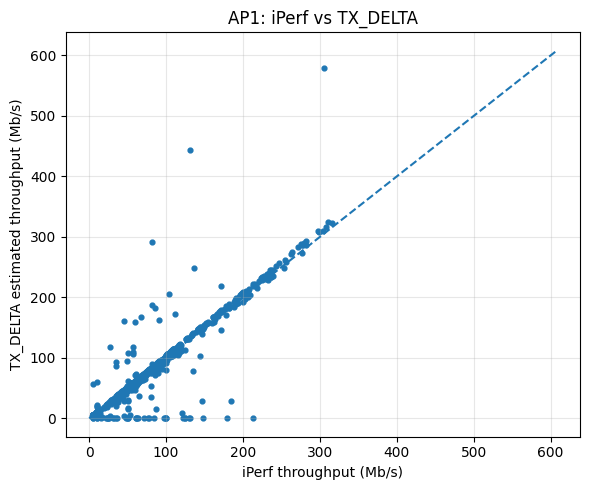

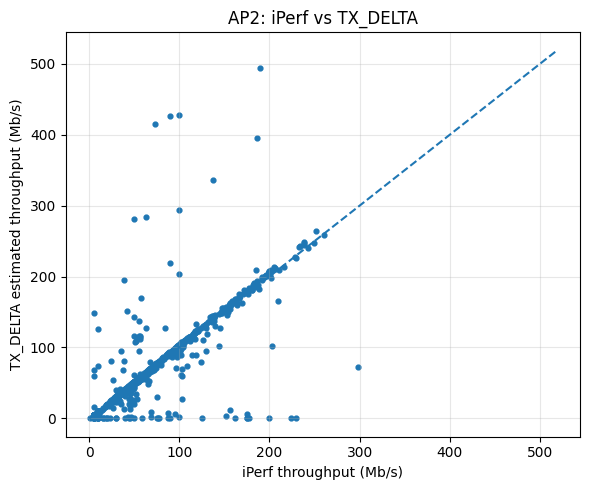

In [15]:
# AP1
x1, y1 = clean_xy(df["ap1_throughput_bps"], df["ap1_txd_estimated_throughput_bps"])
plt.figure(figsize=(6,5))
plt.scatter(to_mbps(x1), to_mbps(y1), s=12)
lims = [
    0, max(np.nanmax(to_mbps(x1)), np.nanmax(to_mbps(y1))) * 1.05 if len(x1)>0 else 1
]
plt.plot([0, lims[1]], [0, lims[1]], linestyle="--")
plt.xlabel("iPerf throughput (Mb/s)")
plt.ylabel("TX_DELTA estimated throughput (Mb/s)")
plt.title("AP1: iPerf vs TX_DELTA")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("fig1a_iperf_vs_txd_AP1.png", dpi=150)
plt.show()

# AP2
x2, y2 = clean_xy(df["ap2_throughput_bps"], df["ap2_txd_estimated_throughput_bps"])
plt.figure(figsize=(6,5))
plt.scatter(to_mbps(x2), to_mbps(y2), s=12)
lims = [
    0, max(np.nanmax(to_mbps(x2)), np.nanmax(to_mbps(y2))) * 1.05 if len(x2)>0 else 1
]
plt.plot([0, lims[1]], [0, lims[1]], linestyle="--")
plt.xlabel("iPerf throughput (Mb/s)")
plt.ylabel("TX_DELTA estimated throughput (Mb/s)")
plt.title("AP2: iPerf vs TX_DELTA")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("fig1b_iperf_vs_txd_AP2.png", dpi=150)
plt.show()


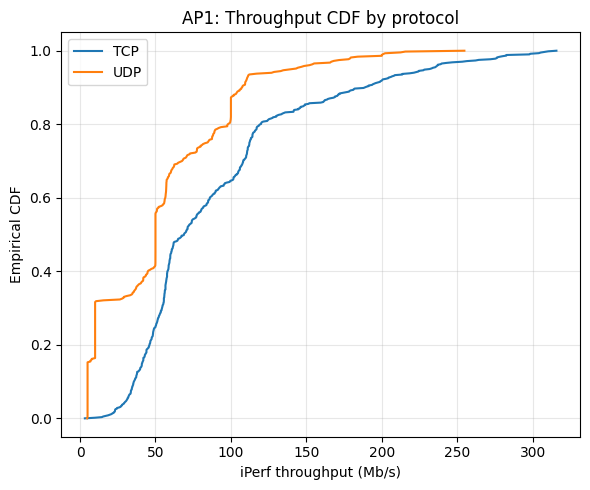

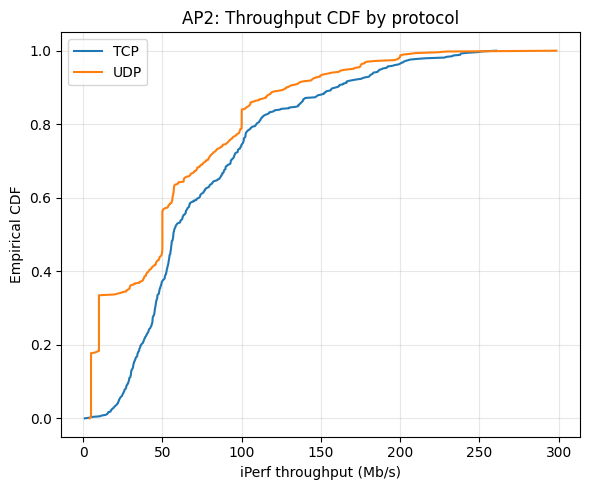

In [16]:
def plot_cdf(values, label=None):
    v = pd.to_numeric(values, errors="coerce").dropna()
    if v.empty:
        return
    v = np.sort(v.values)
    p = np.linspace(0, 1, len(v), endpoint=True)
    plt.plot(to_mbps(v), p, label=label)

# AP1
plt.figure(figsize=(6,5))
for proto, grp in df.groupby("ap1_proto"):
    plot_cdf(grp["ap1_throughput_bps"], label=f"{proto}")
plt.xlabel("iPerf throughput (Mb/s)")
plt.ylabel("Empirical CDF")
plt.title("AP1: Throughput CDF by protocol")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("fig2a_cdf_throughput_by_proto_AP1.png", dpi=150)
plt.show()

# AP2
plt.figure(figsize=(6,5))
for proto, grp in df.groupby("ap2_proto"):
    plot_cdf(grp["ap2_throughput_bps"], label=f"{proto}")
plt.xlabel("iPerf throughput (Mb/s)")
plt.ylabel("Empirical CDF")
plt.title("AP2: Throughput CDF by protocol")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("fig2b_cdf_throughput_by_proto_AP2.png", dpi=150)
plt.show()


/tmp/ipykernel_14068/148485051.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


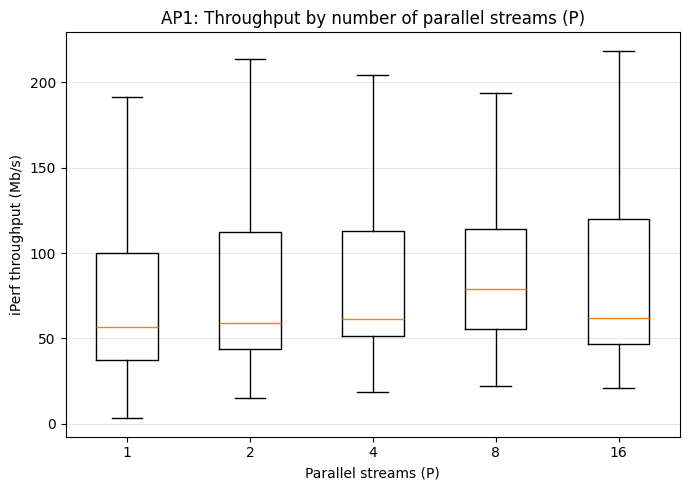

/tmp/ipykernel_14068/148485051.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


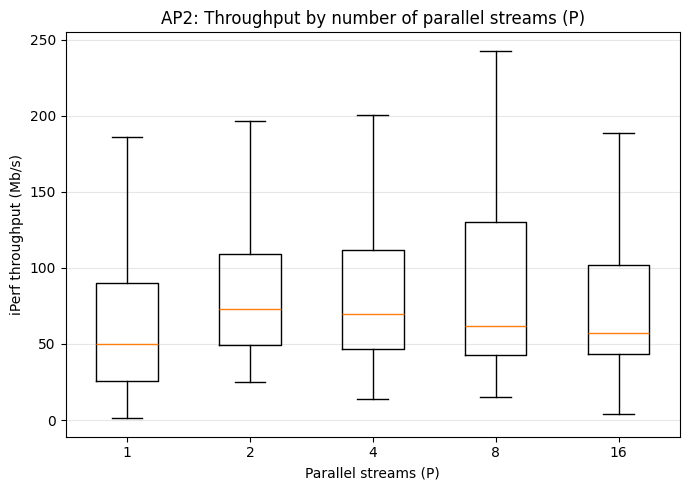

In [17]:
def boxplot_by_streams(df_, y_col, s_col, title, outfile):
    tmp = df_[[y_col, s_col]].copy()
    tmp[y_col] = to_mbps(tmp[y_col])
    tmp = tmp.dropna()
    # ordonner P (1,2,4,8,16)
    order = sorted(tmp[s_col].dropna().unique())
    data = [tmp.loc[tmp[s_col]==k, y_col].values for k in order]
    plt.figure(figsize=(7,5))
    plt.boxplot(data, labels=order, showfliers=False)
    plt.xlabel("Parallel streams (P)")
    plt.ylabel("iPerf throughput (Mb/s)")
    plt.title(title)
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()

boxplot_by_streams(df, "ap1_throughput_bps", "ap1_streams",
                   "AP1: Throughput by number of parallel streams (P)",
                   "fig3a_box_throughput_by_streams_AP1.png")

boxplot_by_streams(df, "ap2_throughput_bps", "ap2_streams",
                   "AP2: Throughput by number of parallel streams (P)",
                   "fig3b_box_throughput_by_streams_AP2.png")


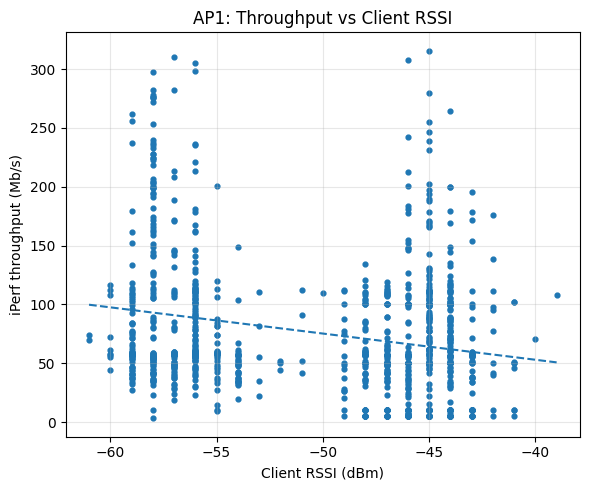

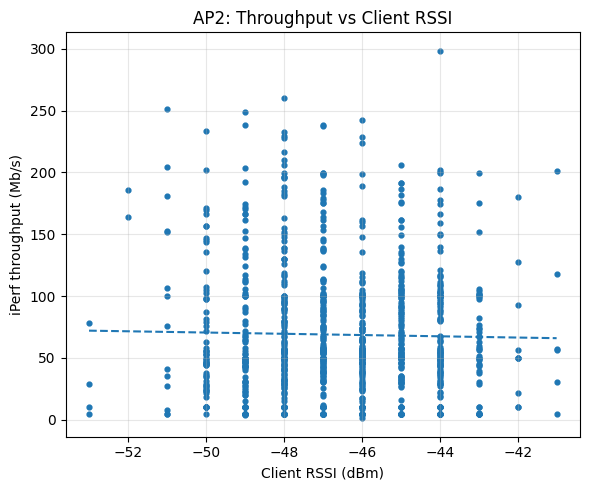

In [18]:
def scatter_with_trend(x, y, title, xlabel, ylabel, outfile):
    X = pd.to_numeric(x, errors="coerce")
    Y = pd.to_numeric(y, errors="coerce")/1e6
    mask = X.notna() & Y.notna() & np.isfinite(X) & np.isfinite(Y)
    Xv, Yv = X[mask].values, Y[mask].values

    plt.figure(figsize=(6,5))
    plt.scatter(Xv, Yv, s=12)
    # Trend line (moindre carrés)
    if len(Xv) >= 2:
        A = np.vstack([Xv, np.ones_like(Xv)]).T
        m, c = np.linalg.lstsq(A, Yv, rcond=None)[0]
        xline = np.linspace(Xv.min(), Xv.max(), 100)
        yline = m*xline + c
        plt.plot(xline, yline, linestyle="--")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()

scatter_with_trend(df["ap1_client_signal_rssi_dbm"], df["ap1_throughput_bps"],
                   "AP1: Throughput vs Client RSSI",
                   "Client RSSI (dBm)", "iPerf throughput (Mb/s)",
                   "fig4a_scatter_throughput_vs_rssi_AP1.png")

scatter_with_trend(df["ap2_client_signal_rssi_dbm"], df["ap2_throughput_bps"],
                   "AP2: Throughput vs Client RSSI",
                   "Client RSSI (dBm)", "iPerf throughput (Mb/s)",
                   "fig4b_scatter_throughput_vs_rssi_AP2.png")


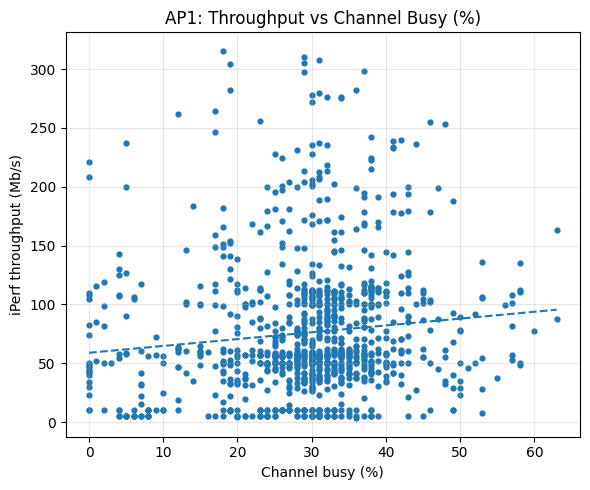

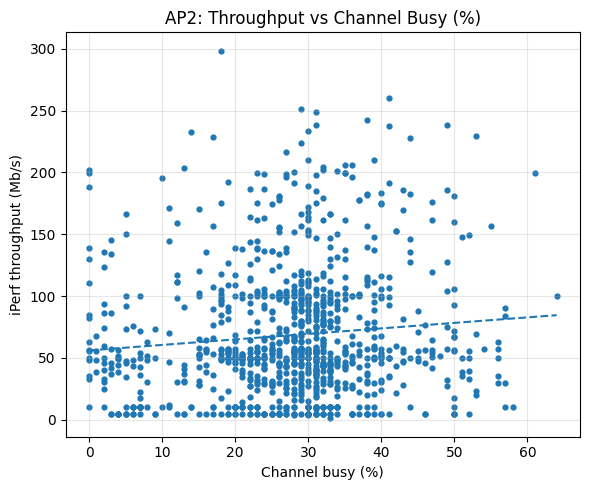

In [19]:
scatter_with_trend(df["ap1_wifi_channel_busy_percent"], df["ap1_throughput_bps"],
                   "AP1: Throughput vs Channel Busy (%)",
                   "Channel busy (%)", "iPerf throughput (Mb/s)",
                   "fig5a_scatter_throughput_vs_busy_AP1.png")

scatter_with_trend(df["ap2_wifi_channel_busy_percent"], df["ap2_throughput_bps"],
                   "AP2: Throughput vs Channel Busy (%)",
                   "Channel busy (%)", "iPerf throughput (Mb/s)",
                   "fig5b_scatter_throughput_vs_busy_AP2.png")


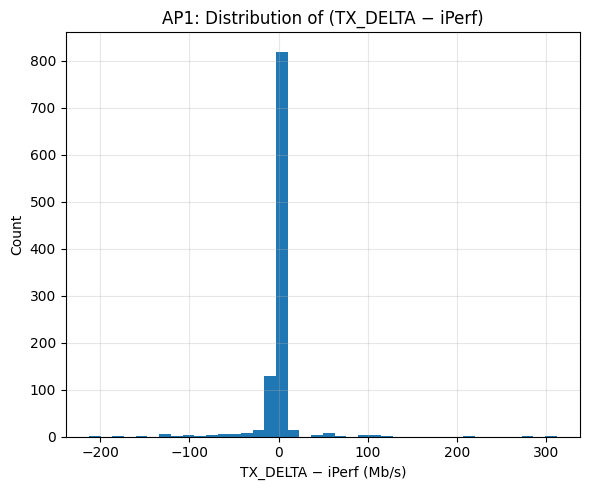

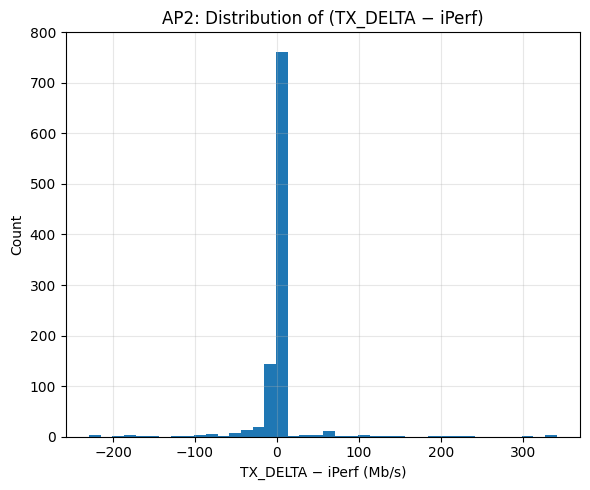

In [20]:
def hist_diff(txd_col, iperf_col, title, outfile):
    txd = pd.to_numeric(df[txd_col], errors="coerce")
    ipf = pd.to_numeric(df[iperf_col], errors="coerce")
    diff_mbps = (txd - ipf) / 1e6
    vals = diff_mbps.dropna().values

    plt.figure(figsize=(6,5))
    plt.hist(vals, bins=40)
    plt.xlabel("TX_DELTA − iPerf (Mb/s)")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=150)
    plt.show()

hist_diff("ap1_txd_estimated_throughput_bps", "ap1_throughput_bps",
          "AP1: Distribution of (TX_DELTA − iPerf)", "fig6a_hist_txd_minus_iperf_AP1.png")

hist_diff("ap2_txd_estimated_throughput_bps", "ap2_throughput_bps",
          "AP2: Distribution of (TX_DELTA − iPerf)", "fig6b_hist_txd_minus_iperf_AP2.png")
